In [50]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import scipy.optimize as optimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [52]:
GLOBAL_FLOAT_PRECISION_NUMPY = np.float64

In [53]:
torch.set_default_dtype(torch.float64)

## Data preparation

In [54]:
compiled_constants_csv_path = r'/content/drive/MyDrive/compiled_data/compiled_constants.csv'
compiled_constants_df = pd.read_csv(compiled_constants_csv_path)
compiled_constants_dtypes = {
	'master_run': 'int32',
	'chirp_direction': 'str',
	'bigT': GLOBAL_FLOAT_PRECISION_NUMPY,
	'Keff': GLOBAL_FLOAT_PRECISION_NUMPY,
	'contrast': GLOBAL_FLOAT_PRECISION_NUMPY,
	'g0': GLOBAL_FLOAT_PRECISION_NUMPY,
	'fringe_offset': GLOBAL_FLOAT_PRECISION_NUMPY
}
compiled_constants_df = compiled_constants_df.astype(compiled_constants_dtypes)

print(compiled_constants_df.shape)
print(compiled_constants_df.head())

(40, 7)
   master_run chirp_direction  bigT          Keff  contrast        g0  \
0       15795        chirp_up  0.01  1.610579e+07  0.077362  9.781717   
1       15795      chirp_down  0.01  1.610579e+07  0.071496 -9.785014   
2       15796        chirp_up  0.01  1.610579e+07  0.089038  9.781654   
3       15796      chirp_down  0.01  1.610579e+07  0.050573 -9.785014   
4       15797        chirp_up  0.01  1.610579e+07  0.037504  9.781175   

   fringe_offset  
0       0.598050  
1       0.558940  
2       0.587497  
3       0.542947  
4       0.539222  


In [55]:
chirp_direction = 'chirp_up'
data_file_path = r'/content/drive/MyDrive/compiled_data/compiled_' + f'{chirp_direction}.pkl'
data_cols = [
		'master_run_number', 'chirp_rate', 'fraction',
		'CA+_mean', 'CA+_std_dev', 'CA+_percentile_0', 'CA+_percentile_10', 'CA+_percentile_20',
		'CA+_percentile_30', 'CA+_percentile_40', 'CA+_percentile_50', 'CA+_percentile_60', 'CA+_percentile_70',
		'CA+_percentile_80', 'CA+_percentile_90', 'CA+_percentile_100', 'CA-_mean', 'CA-_std_dev', 'CA-_percentile_0',
		'CA-_percentile_10', 'CA-_percentile_20', 'CA-_percentile_30', 'CA-_percentile_40', 'CA-_percentile_50',
		'CA-_percentile_60', 'CA-_percentile_70', 'CA-_percentile_80', 'CA-_percentile_90', 'CA-_percentile_100'
	]

data = pd.DataFrame(pd.read_pickle(data_file_path), columns=data_cols, dtype=GLOBAL_FLOAT_PRECISION_NUMPY)
data = data.astype({'master_run_number': 'int32'})
print(data.head())

# 80-20 train/test split
train_data_df = data.sample(frac=0.8, random_state=0)
test_data_df = data.drop(train_data_df.index)

print(train_data_df.shape)
print(test_data_df.shape)
# print(test_data_df.head())

   master_run_number  chirp_rate  fraction     CA+_mean  CA+_std_dev  \
0              15795  25093740.0  0.435512  4271.655457  2025.222384   
1              15795  25096470.0  0.595626  4314.505900  1976.728073   
2              15795  25093110.0  0.435637  4144.249294  1977.968400   
3              15795  25091920.0  0.638270  4285.936412  2025.434123   
4              15795  25096610.0  0.560878  4169.823235  2004.726056   

   CA+_percentile_0  CA+_percentile_10  CA+_percentile_20  CA+_percentile_30  \
0           -3526.0             1709.6             2575.0             3207.0   
1           -3244.0             1810.6             2644.0             3284.0   
2           -3800.0             1629.0             2491.0             3119.0   
3           -3566.0             1722.0             2620.0             3239.0   
4           -3981.0             1634.0             2515.0             3135.0   

   CA+_percentile_40  ...  CA-_percentile_10  CA-_percentile_20  \
0             3755.

## Converting chirp rates to fractions

In [56]:
def sine_torch(alpha, Keff, bigT, contrast, g0, fringe_offset):
    phi = (Keff * g0 - 2 * torch.pi * alpha) * (bigT**2)
    # # To check that we are getting the expected values for phi
    # phi_as_pi_multiples = phi / np.pi
    # print(f'phi: {phi_as_pi_multiples}')
    return (-contrast * torch.cos(phi) + fringe_offset)

In [57]:
def get_chirp_rates_from_noise_torch(outputs, data_df):
	corrected_chirp_rates = outputs + torch.tensor(data_df['chirp_rate'].values).view(-1, 1)
	return corrected_chirp_rates

In [58]:
# shitty impromptu unit testing
t1 = torch.tensor([[1], [2], [3]])
print(t1.shape)
t2 = pd.DataFrame([1, 2, 3], columns=['chirp_rate'])
print(t2)
t3 = get_chirp_rates_from_noise_torch(t1, t2)
print(t3)

torch.Size([3, 1])
   chirp_rate
0           1
1           2
2           3
tensor([[2],
        [4],
        [6]])


In [59]:
def get_predicted_fractions_from_chirp_rates_torch(chirp_rates, data_df):
	predicted_fractions = []
	for index in range(chirp_rates.shape[0]):
		data_row = data_df.iloc[index]
		master_run = data_row['master_run_number']
		compiled_constants_row = compiled_constants_df[(compiled_constants_df['master_run'] == master_run) & (compiled_constants_df['chirp_direction'] == chirp_direction)]

		Keff = compiled_constants_row['Keff'].item()
		bigT = compiled_constants_row['bigT'].item()
		contrast = compiled_constants_row['contrast'].item()
		g0 = compiled_constants_row['g0'].item()
		fringe_offset = compiled_constants_row['fringe_offset'].item()
		alpha = chirp_rates[index]
		predicted_fraction = sine_torch(alpha, Keff, bigT, contrast, g0, fringe_offset)
		predicted_fractions.append(predicted_fraction)

	predicted_fractions_tensor = torch.stack(predicted_fractions, 0)
	return predicted_fractions_tensor


In [60]:
# shitty impromptu unit testing
master_run = 15795
t1 = torch.tensor([[1], [2], [3]])
print(t1.shape)
for i in range(1,4):
	compiled_constants_row = compiled_constants_df[(compiled_constants_df['master_run'] == master_run) & (compiled_constants_df['chirp_direction'] == chirp_direction)]
	Keff = compiled_constants_row['Keff'].item()
	bigT = compiled_constants_row['bigT'].item()
	contrast = compiled_constants_row['contrast'].item()
	g0 = compiled_constants_row['g0'].item()
	fringe_offset = compiled_constants_row['fringe_offset'].item()
	print(Keff, bigT, contrast, g0, fringe_offset)
	alpha = torch.tensor(i)
	predicted_fraction = sine_torch(alpha, Keff, bigT, contrast, g0, fringe_offset)
	print(f'{alpha}: {predicted_fraction:.18f}')

print(f'\n\n')
t2 = get_predicted_fractions_from_chirp_rates_torch(t1, data)
print(f'{t2[0].item():.18f}')
print(f'{t2[1].item():.18f}')
print(f'{t2[2].item():.18f}')

torch.Size([3, 1])
16105786.351132 0.01 0.077362 9.781717 0.59805
1: 0.648325936598004748
16105786.351132 0.01 0.077362 9.781717 0.59805
2: 0.648288982779701151
16105786.351132 0.01 0.077362 9.781717 0.59805
3: 0.648252009127842865



0.648325936598004748
0.648288982779701151
0.648252009127842865


In [61]:
# A little test you can run, to verify that gradients do propagate through this transformation
# https://stackoverflow.com/questions/70426391/how-to-transform-output-of-nn-while-still-being-able-to-train

# start with some random tensor representing the input predictions
# make sure it requires_grad
pred = torch.tensor([[1.0],[1.0],[2.0],[2.0],[10.0],[10.0]]).requires_grad_(True)
print(pred.shape)
# transform it
tpred = get_predicted_fractions_from_chirp_rates_torch(pred, train_data_df)
print(tpred.shape)
# make up some "default" loss function and back-prop
tpred.mean().backward()

# check to see all gradients of the original prediction:
pred.grad

torch.Size([6, 1])
torch.Size([6, 1])


tensor([[-1.1041e-05],
        [-5.3929e-06],
        [-1.1051e-05],
        [-4.4660e-06],
        [-6.9896e-06],
        [-7.6072e-06]])

In [62]:
# A little test you can run, to verify that gradients do propagate through this transformation
# https://stackoverflow.com/questions/70426391/how-to-transform-output-of-nn-while-still-being-able-to-train

# start with some random tensor representing the input predictions
# make sure it requires_grad
pred = torch.rand((train_data_df.shape[0], 1)).requires_grad_(True)
print(pred.shape)
# transform it
tpred = get_chirp_rates_from_noise_torch(pred, train_data_df)
print(tpred.shape)
# make up some "default" loss function and back-prop
tpred.mean().backward()

# check to see all gradients of the original prediction:
pred.grad

torch.Size([1264, 1])
torch.Size([1264, 1])


tensor([[0.0008],
        [0.0008],
        [0.0008],
        ...,
        [0.0008],
        [0.0008],
        [0.0008]])

## Benchmark MSE score

In [63]:
test_chirp_rates = torch.tensor(test_data_df['chirp_rate'].values).view(-1, 1)
test_fractions = torch.tensor(test_data_df['fraction'].values).view(-1, 1)

In [64]:
print(test_chirp_rates.shape)

torch.Size([316, 1])


In [65]:
def get_baseline_score(predicted_tensor, target_tensor, loss_fn):
	loss = loss_fn(predicted_tensor, target_tensor)
	return loss.item()

In [66]:
predicted_fractions_tensor = get_predicted_fractions_from_chirp_rates_torch(test_chirp_rates, test_data_df)

MSELoss = nn.MSELoss()
mse_baseline_score = get_baseline_score(predicted_fractions_tensor, test_fractions, MSELoss)
print(f'MSE baseline score: {mse_baseline_score}')

HuberLoss = nn.SmoothL1Loss()
msle_baseline_score = get_baseline_score(predicted_fractions_tensor, test_fractions, HuberLoss)
print(f'Huber baseline score: {msle_baseline_score}')

MSE baseline score: 0.00439656133251736
Huber baseline score: 0.00219828066625868


## Training

In [67]:
def train(model, optimizer, loss_fn, epochs, train_data_df):
	training_data_tensor, observed_fractions_tensor = model.get_training_data_tensors_from_dataframe(train_data_df)
	loss_values = []
	for epoch in range(epochs):
		model.train()

		# Forward pass: Compute predicted y by passing x to the model
		noise_corrections = model(training_data_tensor)
		chirp_rates = get_chirp_rates_from_noise_torch(noise_corrections, train_data_df)
		predicted_fractions_tensor = get_predicted_fractions_from_chirp_rates_torch(chirp_rates, train_data_df)
		loss = loss_fn(predicted_fractions_tensor, observed_fractions_tensor)
		loss_values.append(loss.item())

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if epoch % (epochs / 10) == 0:
			print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')
			print(f'noise corrections variation: {torch.var(noise_corrections)}')

	plt.figure(figsize=(10, 6))
	plt.plot(range(epochs), loss_values, label='Training Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Loss vs. Epochs')
	plt.legend()
	plt.show()


### Neural Network

In [85]:
def train(model, optimizer, loss_fn, epochs, train_data_df):
	training_data_tensor, observed_fractions_tensor = model.get_training_data_tensors_from_dataframe(train_data_df)
	loss_values = []
	for epoch in range(epochs):
		model.train()

		# Forward pass: Compute predicted y by passing x to the model
		predicted_fractions_tensor = model(training_data_tensor)
		loss = loss_fn(predicted_fractions_tensor, observed_fractions_tensor)
		loss_values.append(loss.item())

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if epoch % (epochs / 10) == 0:
			print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

	plt.figure(figsize=(10, 6))
	plt.plot(range(epochs), loss_values, label='Training Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Loss vs. Epochs')
	plt.legend()
	plt.show()


### Neural Network - 1

In [84]:
class EndToEndModel(nn.Module):
    def __init__(self):
        super(EndToEndModel, self).__init__()
        self.loss_correction_nn = LossCorrectionNN()

    def forward(self, x):
        noise_corrections = self.loss_correction_nn(x)
        chirp_rates = get_chirp_rates_from_noise_torch(noise_corrections, train_data_df)
        predicted_fractions_tensor = get_predicted_fractions_from_chirp_rates_torch(chirp_rates, train_data_df)
        return predicted_fractions_tensor

    def get_training_data_tensors_from_dataframe(self, data_df):
        training_data_tensor = torch.tensor(train_data_df[['CA+_mean', 'CA+_std_dev',
                                             'CA+_percentile_0', 'CA+_percentile_50',
                                             'CA+_percentile_100', 'CA-_mean',
                                             'CA-_std_dev', 'CA-_percentile_0',
                                             'CA-_percentile_50', 'CA-_percentile_100']].values)
        observed_fractions_tensor = torch.tensor(data_df['fraction'].values).view(-1, 1)
        return training_data_tensor, observed_fractions_tensor


In [91]:
end_to_end_model = EndToEndModel()
optimizer = optim.Adam(end_to_end_model.parameters(), lr=0.001)
HuberLoss = nn.SmoothL1Loss()
MSELoss = nn.MSELoss()

Epoch [1/100], Loss: 0.002345121501596261
Epoch [11/100], Loss: 0.00234511699514864
Epoch [21/100], Loss: 0.002345113751371063
Epoch [31/100], Loss: 0.002345104392110588
Epoch [41/100], Loss: 0.002345099402643483
Epoch [51/100], Loss: 0.0023450914665796873
Epoch [61/100], Loss: 0.002345084973477658
Epoch [71/100], Loss: 0.0023450791129034855
Epoch [81/100], Loss: 0.0023450660201919027
Epoch [91/100], Loss: 0.002345061000223344


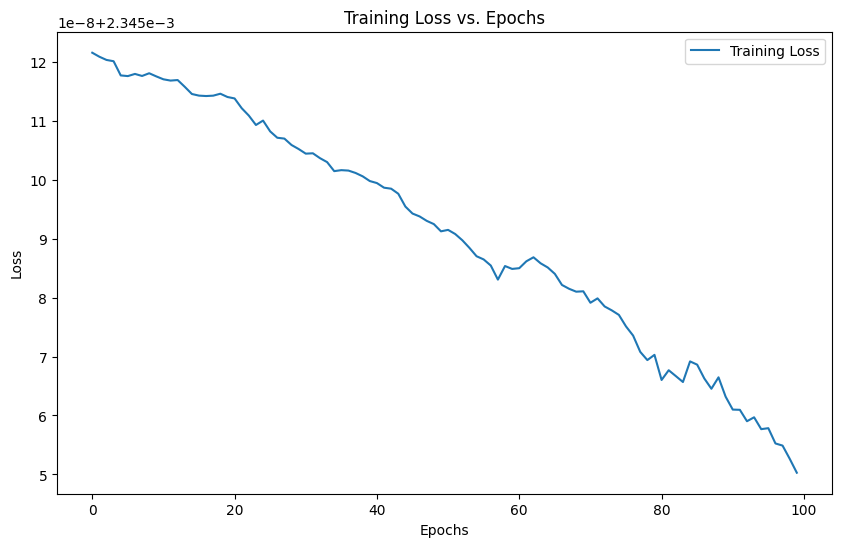

In [87]:
train(end_to_end_model, optimizer, HuberLoss, 100, train_data_df)

### Using scipy-optimize

In [ ]:
def sine_np(alpha, Keff, bigT, contrast, g0, fringe_offset):
    phi = (Keff * g0 - 2 * np.pi * alpha) * (bigT**2)
    return (-contrast * np.cos(phi) + fringe_offset)

def get_predicted_fractions_from_chirp_rates_np(chirp_rates, data_df):
    predicted_fractions = []
    for index in range(chirp_rates.shape[0]):
        data_row = data_df.iloc[index]
        master_run = data_row['master_run_number']
        compiled_constants_row = compiled_constants_df[(compiled_constants_df['master_run'] == master_run) & (compiled_constants_df['chirp_direction'] == chirp_direction)]
        Keff = compiled_constants_row['Keff'].item()
        bigT = compiled_constants_row['bigT'].item()
        contrast = compiled_constants_row['contrast'].item()
        g0 = compiled_constants_row['g0'].item()
        fringe_offset = compiled_constants_row['fringe_offset'].item()
        alpha = chirp_rates[index]
        predicted_fraction = sine(alpha, Keff, bigT, contrast, g0, fringe_offset)
        predicted_fractions.append(predicted_fraction)

    return np.array(predicted_fractions)

def objective_function_np(noise_correction, chirp_rates, data_df, observed_fractions):
    corrected_chirp_rates = chirp_rates + noise_correction
    predicted_fractions = get_predicted_fractions_from_chirp_rates(corrected_chirp_rates, data_df)
    return np.mean((predicted_fractions - observed_fractions)**2)

def find_optimal_correction(chirp_rates, data_df, observed_fractions):
    result = optimize.minimize(objective_function, x0=0,
                               args=(chirp_rates, data_df, observed_fractions),
                               method='Nelder-Mead')
    return result.x[0]

## Evaluation

In [89]:
def get_model_score(predicted_tensor, target_tensor, loss_fn):
	loss = loss_fn(predicted_tensor, target_tensor)
	return loss.item()

In [93]:
test_noise_tensor = torch.tensor(test_data_df[['CA+_mean', 'CA+_std_dev',
                                             'CA+_percentile_0', 'CA+_percentile_50',
                                             'CA+_percentile_100', 'CA-_mean',
                                             'CA-_std_dev', 'CA-_percentile_0',
                                             'CA-_percentile_50', 'CA-_percentile_100']].values)
# Set model to evaluation mode
end_to_end_model.eval()

# Forward pass through the model
with torch.no_grad():
    predicted_fractions = end_to_end_model(test_noise_tensor)

test_fractions_shape_corrected = test_fractions.view(-1, 1)
mse_model_score = get_model_score(predicted_fractions, test_fractions_shape_corrected, MSELoss)
print(f'MSE model score: {mse_model_score}')

msle_model_score = get_model_score(predicted_fractions, test_fractions_shape_corrected, MSLELoss)
print(f'MSLE model score: {msle_model_score}')

RuntimeError: The size of tensor a (316) must match the size of tensor b (1264) at non-singleton dimension 0

In [ ]:
# given a master_un and chirp_direction plot the predicted fraction vs the actual fraction
def plot_predicted_vs_actual(master_run_number):
	master_run_data = data[data['master_run_number'] == master_run_number]
	chirp_rates_original = torch.tensor(master_run_data['chirp_rate'].values)
	observed_fractions = master_run_data['fraction'].values

	expected_fractions_with_original_chirp_rates = get_predicted_fractions_from_chirp_rates(torch.tensor(chirp_rates_original), master_run_data)

	model.eval()
	with torch.no_grad():
		noise_corrections = model(torch.tensor(master_run_data[['CA+_mean', 'CA+_std_dev','CA+_percentile_0', 'CA+_percentile_100', 'CA-_mean', 'CA-_std_dev', 'CA-_percentile_0', 'CA-_percentile_100']].values))
		corrected_chirp_rates = get_chirp_rates_from_noise(noise_corrections, master_run_data)
		expected_fractions_with_corrected_chirp_rates = get_predicted_fractions_from_chirp_rates(corrected_chirp_rates, master_run_data)

	plt.figure(figsize=(10, 6))
	plt.scatter(chirp_rates_original, observed_fractions, label='Observed Fractions')
	plt.scatter(chirp_rates_original, expected_fractions_with_original_chirp_rates, label='Predicted Fractions with Original Chirp Rates')
	plt.show()

	print(corrected_chirp_rates)
	plt.scatter(corrected_chirp_rates, observed_fractions, label='Observed Fractions')
	plt.scatter(corrected_chirp_rates, expected_fractions_with_corrected_chirp_rates, label='Predicted Fractions with Corrected Chirp Rates')
	plt.show()

In [ ]:
plot_predicted_vs_actual(15795)